In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('russian'))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [60]:
df = pd.read_csv('train_tin.csv', encoding='WINDOWS-1251')
df.head()

,text,isPositive
0,"27.09.19 через сайт в разделе ""Рефинансировани...",0
1,Добрый день! Неоднократно поступают звонки по ...,0
2,В первый раз решила воспользоваться кредитной ...,0
3,На самом дело уже накипело из-за участившегося...,0
4,Если вы дорожите своими нервами - ни при каких...,0


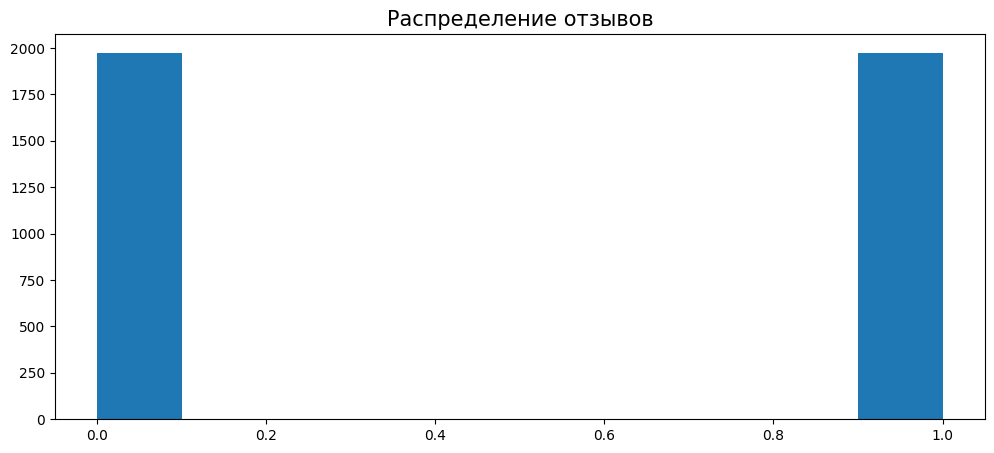

In [61]:
plt.figure(figsize=(12, 5))
plt.hist(df['isPositive'])
plt.title('Распределение отзывов', size=15)
plt.show()

In [62]:
# обработка текста
def data_preprocessing(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    text = ''.join([c for c in text if c not in string.digits])
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

In [63]:
df['cleaned_text'] = df['text'].apply(data_preprocessing)
df.head()

,text,isPositive,cleaned_text
0,"27.09.19 через сайт в разделе ""Рефинансировани...",0,сайт разделе рефинансирование сторонних кредит...
1,Добрый день! Неоднократно поступают звонки по ...,0,добрый день неоднократно поступают звонки долж...
2,В первый раз решила воспользоваться кредитной ...,0,первый решила воспользоваться кредитной картой...
3,На самом дело уже накипело из-за участившегося...,0,самом дело накипело изза участившегося намахал...
4,Если вы дорожите своими нервами - ни при каких...,0,дорожите своими нервами каких обстоятельствах ...


In [64]:
# Каноническая форма слова 
wn_lemmatizer = WordNetLemmatizer()

lemmatized_text = []
for review in df['cleaned_text']:
    lemmatized_text.append(' '.join([wn_lemmatizer.lemmatize(word) for word in review.split()]))

In [65]:
# разбиваю текст на токены
reg_tokenizer = RegexpTokenizer('\w+')  
tokenized_text = reg_tokenizer.tokenize_sents(lemmatized_text)

clean_tokenized_review = [] 
for i, element in enumerate(tokenized_text):
    clean_tokenized_review.append(' '.join([word for word in element if word not in stop_words]))

In [66]:
# Считаю количество повторений каждого слова 
corpus = [word for text in df['cleaned_text'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

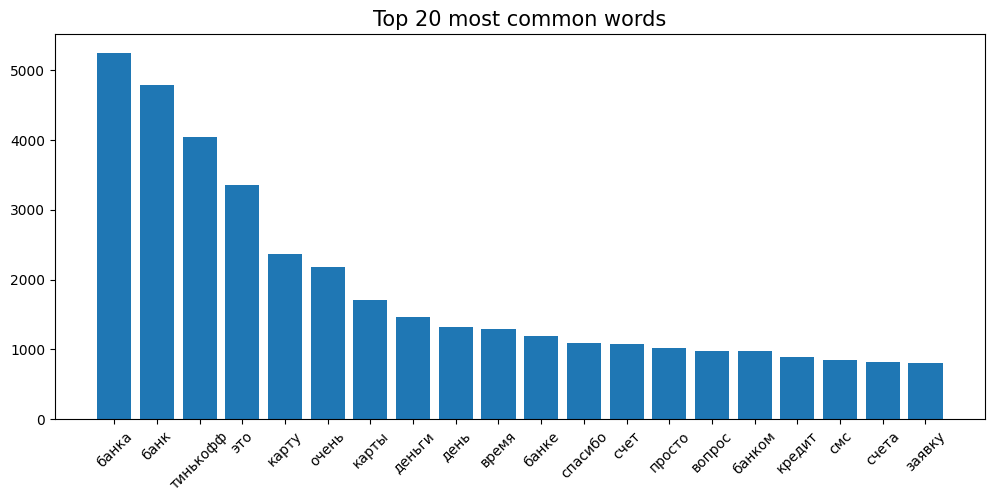

In [67]:
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)
    
plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.xticks(rotation= 45)
plt.title('Top 20 most common words', size=15)
plt.show()

In [68]:
# Длинна отзыва
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
reviews_int = []
for text in df['cleaned_text']:
    r = [vocab_to_int[word] for word in text.split()]
    reviews_int.append(r)
review_len = [len(x) for x in reviews_int]
df['Review_len'] = review_len
df.head()

,text,isPositive,cleaned_text,Review_len
0,"27.09.19 через сайт в разделе ""Рефинансировани...",0,сайт разделе рефинансирование сторонних кредит...,292
1,Добрый день! Неоднократно поступают звонки по ...,0,добрый день неоднократно поступают звонки долж...,81
2,В первый раз решила воспользоваться кредитной ...,0,первый решила воспользоваться кредитной картой...,124
3,На самом дело уже накипело из-за участившегося...,0,самом дело накипело изза участившегося намахал...,337
4,Если вы дорожите своими нервами - ни при каких...,0,дорожите своими нервами каких обстоятельствах ...,310


count    3950.00000
mean       97.98557
std        82.02100
min         5.00000
25%        42.00000
50%        70.00000
75%       122.00000
max       815.00000
Name: Review_len, dtype: float64


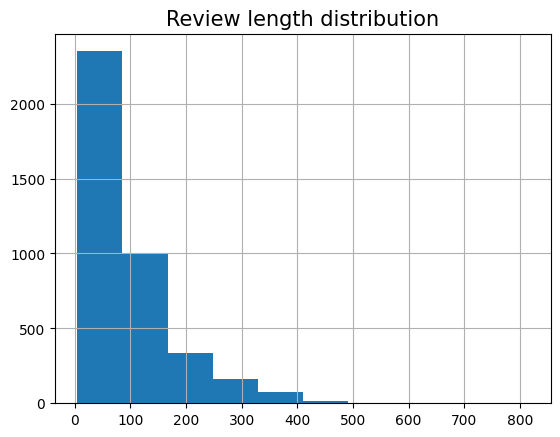

In [69]:
print(df['Review_len'].describe())

df['Review_len'].hist()
plt.title('Review length distribution', size=15)
plt.show()

In [70]:
cvec = CountVectorizer(ngram_range=(1, 1))
tfid = TfidfVectorizer(ngram_range=(1, 1))
tsvd = TruncatedSVD(5)

In [71]:
cvec_representation = cvec.fit_transform(pd.Series(clean_tokenized_review))
tfid_representation = tfid.fit_transform(pd.Series(clean_tokenized_review))
red_tf = tsvd.fit_transform(tfid_representation)

In [77]:
rf = RandomForestClassifier()
lrc = LogisticRegression(max_iter=10000)
svc = SVC()

In [78]:
clfs = {
    'RandomForest' : rf ,
    'LogisticRegression' : lrc,
    'SVC' : svc
    }

In [79]:
def get_scores(clfs, n_cv= 2):
    results = {}
    
    for clf in clfs: 
        cvec_scores = cross_val_score(clfs[clf], cvec_representation, df['isPositive'], n_jobs= -1, cv= n_cv, scoring= 'accuracy')
        tfidf_scores = cross_val_score(clfs[clf], tfid_representation,  df['isPositive'], n_jobs= -1, cv= n_cv, scoring= 'accuracy')
        tsvd_scores = cross_val_score(clfs[clf], red_tf,  df['isPositive'], n_jobs= 4, cv= n_cv, scoring= 'accuracy')

        cvec_mean_score, cvec_std_score = np.mean(cvec_scores), np.std(cvec_scores)
        tfidf_mean_score, tfidf_std_score = np.mean(tfidf_scores), np.std(tfidf_scores)
        tsvd_mean_score, tsvd_std_score = np.mean(tsvd_scores), np.std(tsvd_scores)
    
        results.update({clf : [cvec_mean_score,  
                               tfidf_mean_score,
                               tsvd_mean_score]})
    return results
        

In [80]:
results = pd.DataFrame(get_scores(clfs, 2), index=['BagOfWords', 'TfIdf', 'SVD'])
results

,RandomForest,LogisticRegression,SVC
BagOfWords,0.888354,0.927342,0.899747
TfIdf,0.894684,0.932405,0.934937
SVD,0.909367,0.902278,0.912911


In [48]:
x_train, x_valid, y_train, y_valid = train_test_split(tfid_representation, df['isPositive'], random_state=42, test_size = 0.3)

In [86]:
svc.fit(x_train, y_train)

SVC()

In [89]:
print("Train acc:", round(accuracy_score(svc.predict(x_train), y_train), 2))
print("Valid acc:", round(accuracy_score(svc.predict(x_valid), y_valid), 2))

Train acc: 1.0
Valid acc: 0.95
